# 소개 #

필요한 설정을 위해 이 셀을 실행하세요!


In [1]:
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [3]:
store_sales_time_series_forecasting_path = kagglehub.competition_download('store-sales-time-series-forecasting')
ryanholbrook_ts_course_data_path = kagglehub.dataset_download('ryanholbrook/ts-course-data')

print('Data source import complete.')


100%|██████████| 21.4M/21.4M [00:00<00:00, 189MB/s]

Extracting files...


100%|██████████| 120k/120k [00:00<00:00, 39.1MB/s]

Extracting files...
Data source import complete.


In [4]:
import os
from pathlib import Path

# Define the target directory where learntools expects to find the data
input_base_path = Path('/input')
input_base_path.mkdir(parents=True, exist_ok=True)

# Create a symbolic link for the store-sales-time-series-forecasting competition data
symlink_target_comp = input_base_path / 'store-sales-time-series-forecasting'
symlink_source_comp = store_sales_time_series_forecasting_path

if symlink_target_comp.exists() or symlink_target_comp.is_symlink():
    if symlink_target_comp.is_symlink():
        os.unlink(symlink_target_comp)
    else:
        # If it's a directory, remove it to replace with symlink
        import shutil
        shutil.rmtree(symlink_target_comp)

os.symlink(symlink_source_comp, symlink_target_comp)
print(f"Created symlink: {symlink_target_comp} -> {symlink_source_comp}")

# Create a symbolic link for the ryanholbrook/ts-course-data dataset
symlink_target_data = input_base_path / 'ts-course-data'
symlink_source_data = ryanholbrook_ts_course_data_path

if symlink_target_data.exists() or symlink_target_data.is_symlink():
    if symlink_target_data.is_symlink():
        os.unlink(symlink_target_data)
    else:
        import shutil
        shutil.rmtree(symlink_target_data)

os.symlink(symlink_source_data, symlink_target_data)
print(f"Created symlink: {symlink_target_data} -> {symlink_source_data}")

# Also update the data_dir and comp_dir variables in the current scope for consistency if needed
# For this notebook, the main loading cell (646100dd) explicitly uses the kagglehub paths,
# but the learntools checking utilities rely on the symlinks we just created.
# So, no direct reassignment of data_dir/comp_dir in this cell is strictly necessary for the next steps.


Created symlink: /input/store-sales-time-series-forecasting -> /root/.cache/kagglehub/competitions/store-sales-time-series-forecasting
Created symlink: /input/ts-course-data -> /root/.cache/kagglehub/datasets/ryanholbrook/ts-course-data/versions/14


In [5]:
!git clone https://github.com/Kaggle/learntools.git
!mv learntools learntools_dir
!mv learntools_dir/learntools learntools

Cloning into 'learntools'...
remote: Enumerating objects: 18766, done.
remote: Counting objects: 100% (314/314), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 18766 (delta 243), reused 165 (delta 155), pack-reused 18452 (from 3)
Receiving objects: 100% (18766/18766), 105.27 MiB | 28.30 MiB/s, done.
Resolving deltas: 100% (13801/13801), done.


# 시계열(Time Series)에 오신 것을 환영합니다! #

**예측(Forecasting)**은 현실 세계에서 머신러닝이 가장 많이 쓰이는 활용 사례일지도 모릅니다. 기업은 제품 수요를 예측하고, 정부는 경제와 인구 성장을 예측하며, 기상학자는 날씨를 예측합니다. 과학·정부·산업 전반(그리고 우리의 일상 생활까지)에서 미래를 이해하려는 수요가 매우 크고, 이런 분야의 실무자들은 이 필요를 해결하기 위해 점점 더 머신러닝을 적용하고 있습니다.

시계열 예측은 역사가 길고 폭넓은 분야입니다. 이 강의는 가장 정확한 예측을 만들어내는 것을 목표로, 현대 머신러닝 기법을 시계열 데이터에 적용하는 방법에 집중합니다. 여기에서 소개하는 수업들은 과거 Kaggle 예측 대회의 우승 솔루션에서 영감을 받았지만, 정확도가 중요한 어떤 예측 작업에도 활용할 수 있습니다.

이 과정을 마치면 다음을 할 수 있습니다.
- 주요 시계열 구성 요소(*추세*, *계절성*, *주기*)를 모델링하는 피처를 설계한다.
- 다양한 *시계열 그래프*로 시계열을 시각화한다.
- 서로 보완적인 모델의 장점을 결합한 예측 *하이브리드*를 만든다.
- 여러 종류의 예측 과제에 맞춰 머신러닝 기법을 변형한다.

실습의 일부로 [Store Sales - Time Series Forecasting](https://www.kaggle.com/c/29781) 입문 대회에도 참여해 볼 수 있습니다. 이 대회에서는 에콰도르의 대형 식료품 소매업체인 *Corporación Favorita*의 거의 1800개 제품군에 대해 매출을 예측해야 합니다.

# 시계열(Time Series)이란? #

예측의 기본 대상은 시간에 따라 기록된 관측들의 집합인 **시계열**입니다. 예측 문제에서는 관측값을 하루 혹은 한 달처럼 규칙적인 주기로 기록하는 경우가 일반적입니다.


In [6]:

import pandas as pd

df = pd.read_csv(
    input_base_path / 'ts-course-data'/ 'book_sales.csv',
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)

df.head()

,Hardcover
Date,
2000-04-01,139
2000-04-02,128
2000-04-03,172
2000-04-04,139
2000-04-05,191


이 시계열은 30일 동안 한 소매점에서 판매된 양장본 도서 수를 기록합니다. `Date`라는 시간 인덱스와 `Hardcover`라는 단일 관측 열이 있다는 점을 확인하세요.

# 시계열과 선형 회귀 #

강의의 첫 부분에서는 선형 회귀 알고리즘으로 예측 모델을 만들어 봅니다. 선형 회귀는 실무에서 널리 쓰이고, 복잡한 예측 과제에도 자연스럽게 적용할 수 있습니다.

**선형 회귀(linear regression)** 알고리즘은 입력 피처를 가중합하는 방법을 학습합니다. 피처가 두 개라면 다음과 같은 형태가 됩니다.

```
target = weight_1 * feature_1 + weight_2 * feature_2 + bias
```

훈련 과정에서 회귀 알고리즘은 `target`에 가장 잘 맞도록 `weight_1`, `weight_2`, `bias` 값을 학습합니다. (예측값과 타깃 사이의 제곱 오차를 최소화하는 값을 고르기 때문에 *최소제곱법(ordinary least squares)*이라고도 부릅니다.) 가중치는 *회귀 계수*라고 하며, `bias`는 이 함수의 그래프가 y축을 가로지르는 지점을 알려준다고 해서 *절편(intercept)*이라고 부릅니다.

### 시간 단계(Time-step) 피처

시계열에서만 사용되는 피처는 시간 단계 피처와 래그 피처 두 가지입니다.

시간 단계 피처는 시간 인덱스에서 직접 도출할 수 있는 피처입니다. 가장 기본적인 시간 단계 피처는 시계열의 시작부터 끝까지 시간 단계를 세어 주는 **타임 더미(time dummy)** 입니다.


In [7]:

import numpy as np

df['Time'] = np.arange(len(df.index))

df.head()

,Hardcover,Time
Date,,
2000-04-01,139,0
2000-04-02,128,1
2000-04-03,172,2
2000-04-04,139,3
2000-04-05,191,4


타임 더미를 사용한 선형 회귀 모델은 다음과 같습니다.

```
target = weight * time + bias
```

타임 더미를 활용하면 `Time`이 x축이 되는 *시계열 플롯*에서 시계열에 곡선을 맞출 수 있습니다.


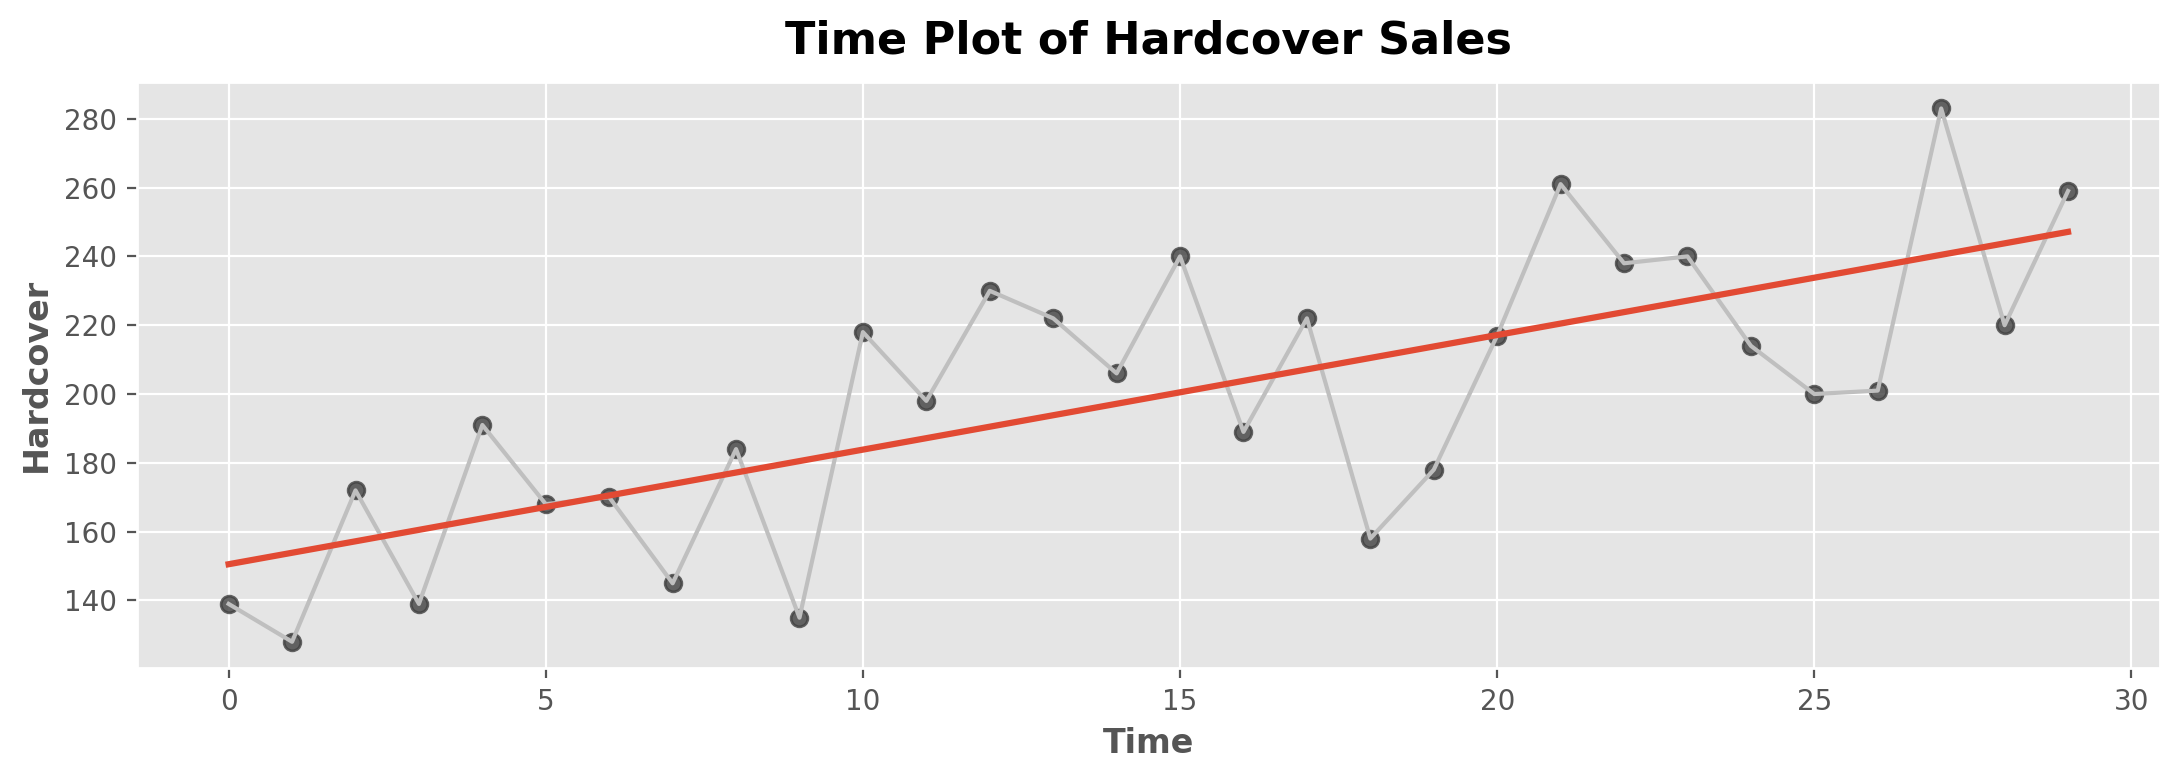

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot") # Changed from "seaborn-whitegrid"
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=df, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');

시간 단계 피처를 사용하면 **시간 의존성(time dependence)** 을 모델링할 수 있습니다. 시계열의 값이 발생한 시점만으로도 예측 가능하다면 그 시계열은 시간 의존적이라고 합니다. *Hardcover Sales* 시계열에서는 월말 판매량이 월초보다 대체로 높다는 사실을 예측할 수 있습니다.

### 래그(Lag) 피처

**래그 피처**는 타깃 시계열의 관측값을 뒤쪽으로 이동시켜 더 나중에 발생한 것처럼 만드는 방식입니다. 여기서는 1스텝 래그 피처를 만들었지만, 여러 스텝을 이동시키는 것도 가능합니다.


In [9]:

df['Lag_1'] = df['Hardcover'].shift(1)
df = df.reindex(columns=['Hardcover', 'Lag_1'])

df.head()

,Hardcover,Lag_1
Date,,
2000-04-01,139,NaN
2000-04-02,128,139.0
2000-04-03,172,128.0
2000-04-04,139,172.0
2000-04-05,191,139.0


래그 피처를 사용한 선형 회귀 모델은 다음과 같습니다.

```
target = weight * lag + bias
```

따라서 래그 피처를 사용하면 시계열의 각 관측값을 이전 관측값과 짝지어 표현하는 *래그 플롯*에 곡선을 맞출 수 있습니다.


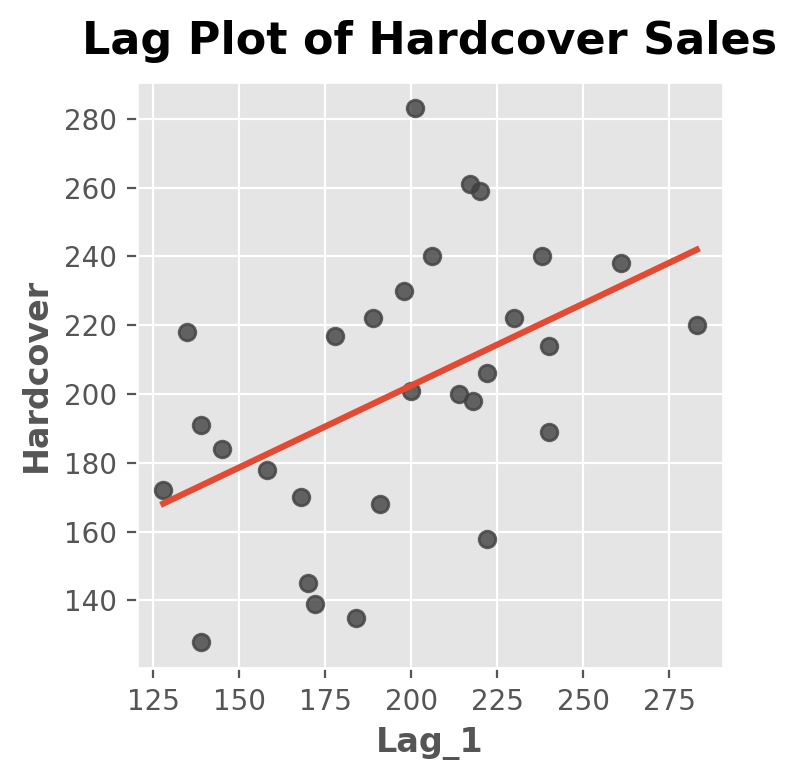

In [10]:

fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales');

래그 플롯을 보면 어느 날의 판매량(`Hardcover`)이 전날 판매량(`Lag_1`)과 상관관계가 있다는 것을 알 수 있습니다. 이런 관계가 보일 때는 래그 피처가 유용하다는 뜻입니다.

좀 더 일반적으로, 래그 피처는 **계열 의존성(serial dependence)** 을 모델링하게 해 줍니다. 이전 관측값으로 현재 관측값을 예측할 수 있다면 그 시계열은 계열 의존성을 가진다고 합니다. *Hardcover Sales*에서는 특정 날의 판매량이 높으면 다음 날도 높은 경우가 많다고 예측할 수 있습니다.

---

머신러닝 알고리즘을 시계열 문제에 맞추는 핵심은 시간 인덱스와 래그를 이용한 피처 엔지니어링입니다. 강의 대부분에서 단순함 때문에 선형 회귀를 사용하지만, 어떤 알고리즘을 선택하든 이런 피처는 예측 작업에 도움이 됩니다.

# 예제 - 터널 교통량 #

*Tunnel Traffic*은 스위스의 Baregg Tunnel를 하루마다 지나는 차량 수를 2003년 11월부터 2005년 11월까지 기록한 시계열입니다. 이 예제에서는 시간 단계 피처와 래그 피처에 선형 회귀를 적용하는 연습을 합니다.

숨겨진 셀에서 필요한 설정을 모두 수행했습니다.


In [11]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("ggplot") # Changed from "seaborn-whitegrid"
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
data_dir = input_base_path / 'ts-course-data'
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])

# Create a time series in Pandas by setting the index to a date
# column. We parsed "Day" as a date type by using `parse_dates` when
# loading the data.
tunnel = tunnel.set_index("Day")

# By default, Pandas creates a `DatetimeIndex` with dtype `Timestamp`
# (equivalent to `np.datetime64`, representing a time series as a
# sequence of measurements taken at single moments. A `PeriodIndex`,
# on the other hand, represents a time series as a sequence of
# quantities accumulated over periods of time. Periods are often
# easier to work with, so that's what we'll use in this course.
tunnel = tunnel.to_period()

tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


### 시간 단계 피처

시계열에 누락된 날짜가 없다면, 전체 길이를 세어 타임 더미를 만들 수 있습니다.


In [12]:
df = tunnel.copy()

df['Time'] = np.arange(len(tunnel.index))

df.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


선형 회귀 모델을 학습하는 절차는 scikit-learn의 표준 단계와 동일합니다.


In [13]:
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'NumVehicles']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

실제로 만들어진 모델은 대략 `Vehicles = 22.5 * Time + 98176` 입니다. 예측값을 시간축에 그려 보면 타임 더미에 선형 회귀를 맞춰서 이 방정식이 나타내는 추세선을 어떻게 얻는지 확인할 수 있습니다.


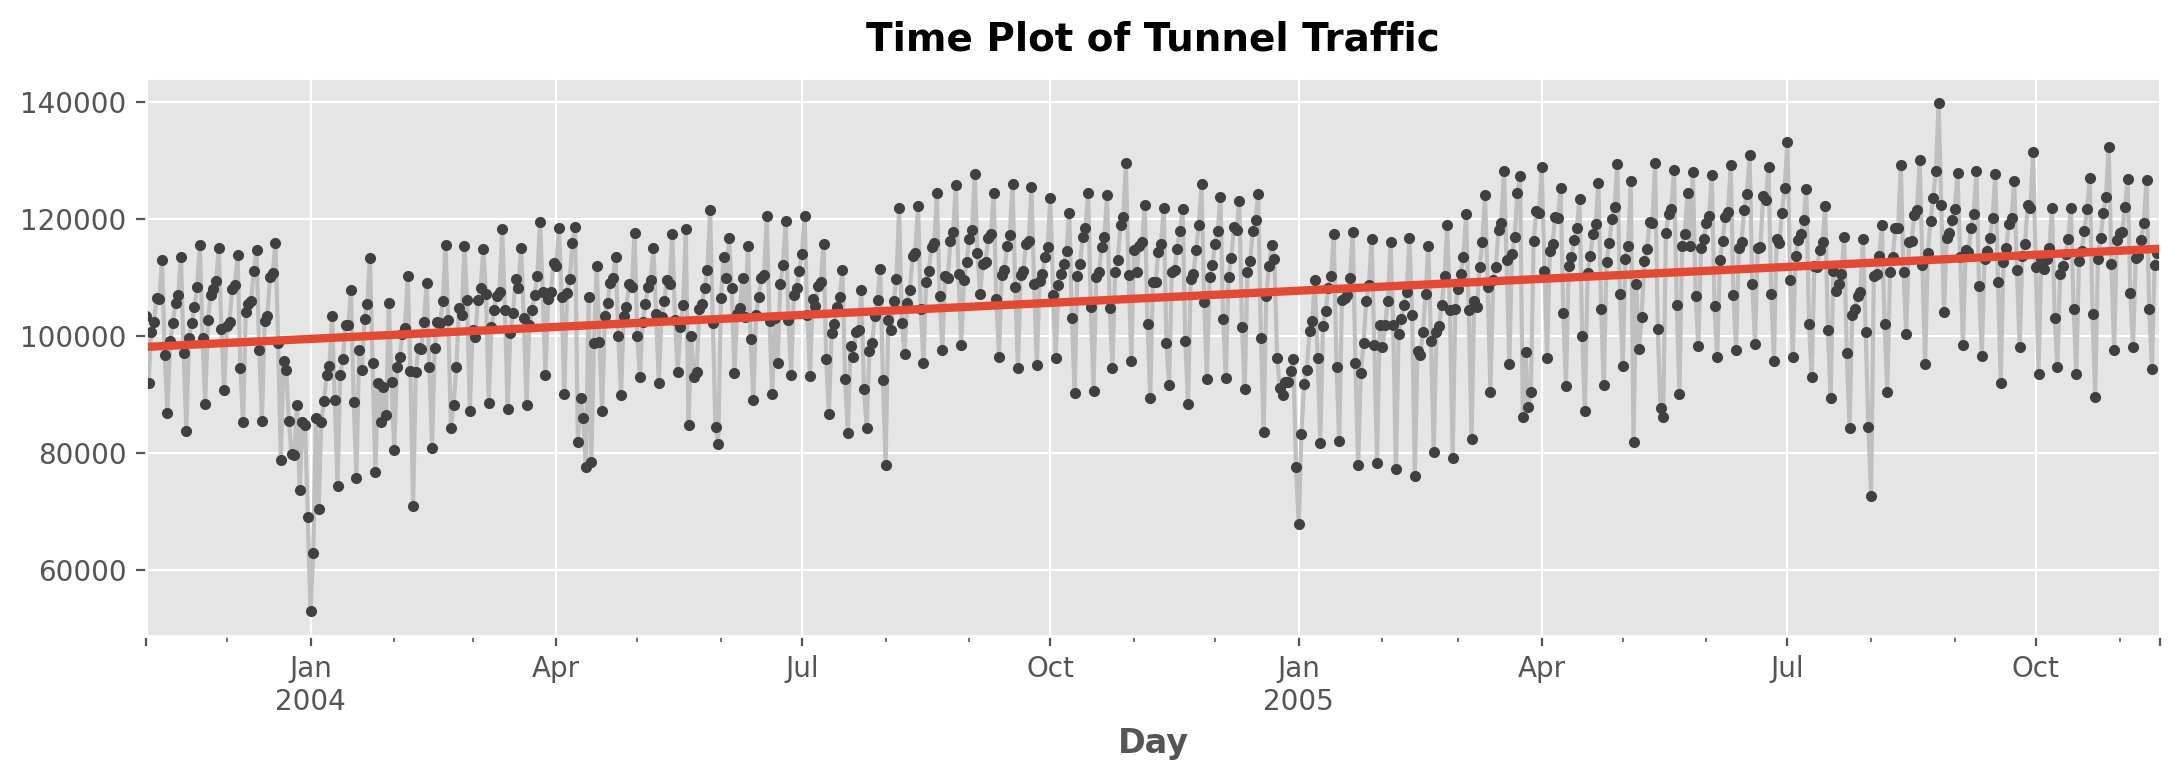

In [14]:

ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

### 래그 피처

Pandas에는 시계열을 쉽게 이동시키는 `shift` 메서드가 있습니다.


In [15]:
df['Lag_1'] = df['NumVehicles'].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


래그 피처를 만들면 결측값이 생기는데, 이를 어떻게 처리할지 결정해야 합니다. 0.0으로 채우거나 첫 번째로 관측된 값으로 "뒤채움(backfill)"을 할 수도 있습니다. 여기서는 대신 결측값을 삭제하고, 동일한 날짜의 타깃 값도 함께 제거하겠습니다.


In [16]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'NumVehicles']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

래그 플롯을 보면 하루 전 차량 수와 하루 후 차량 수 사이의 관계를 얼마나 잘 맞췄는지 확인할 수 있습니다.


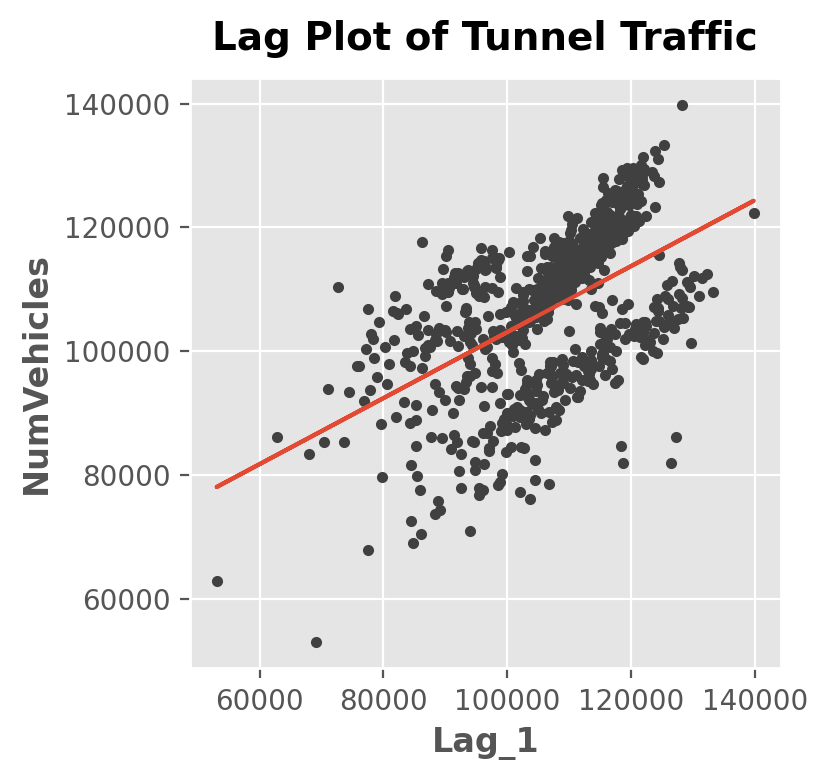

In [17]:

fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic');

래그 피처에서 나온 이 예측은 시계열 전체에 대해 어느 정도까지 예측할 수 있음을 의미할까요? 아래의 시계열 플롯을 보면 최근 과거의 패턴에 맞춰 우리의 예측이 어떻게 반응하는지 확인할 수 있습니다.


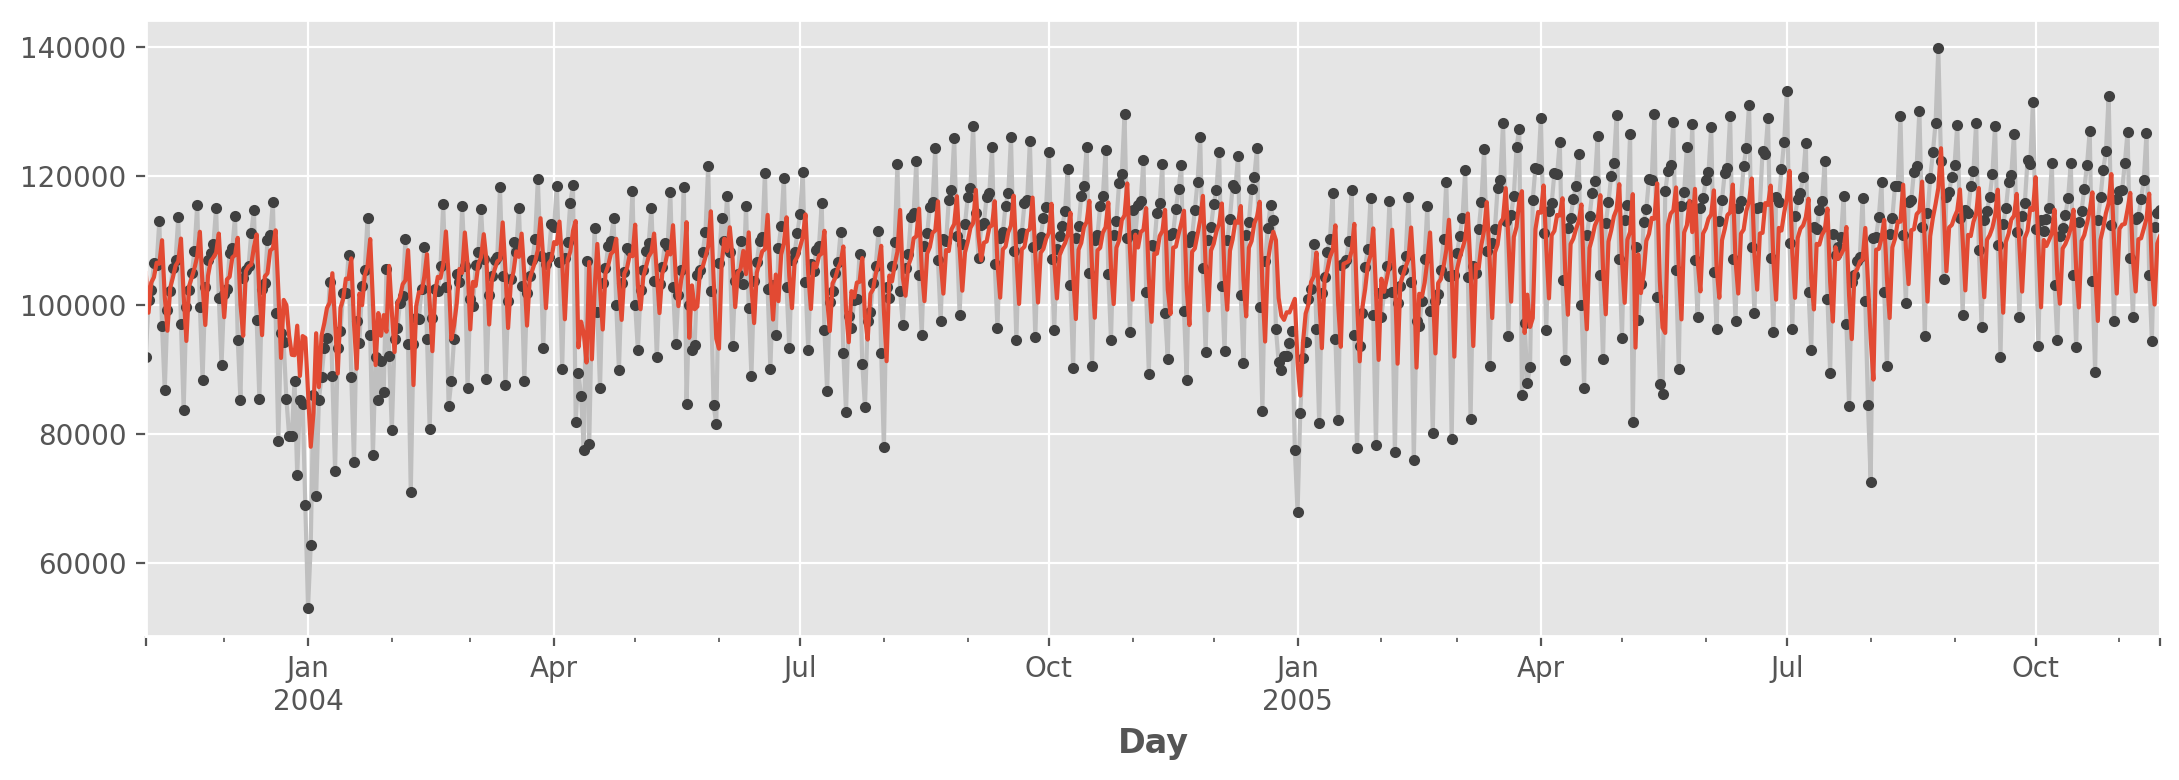

In [18]:

ax = y.plot(**plot_params)
ax = y_pred.plot()

최고의 시계열 모델은 보통 시간 단계 피처와 래그 피처를 적절히 조합합니다. 다음 강의들에서는 이번 강의에서 다룬 피처를 출발점으로 삼아, 시계열에서 흔히 나타나는 패턴을 모델링하는 피처 엔지니어링 기법을 배워 보겠습니다.


#*연습문제*

셋팅 코드

In [19]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex1 import *

# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression


data_dir = symlink_target_data
comp_dir = symlink_source_data

book_sales = pd.read_csv(
    input_base_path / 'ts-course-data' / 'book_sales.csv',
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)
book_sales['Time'] = np.arange(len(book_sales.index))
book_sales['Lag_1'] = book_sales['Hardcover'].shift(1)
book_sales = book_sales.reindex(columns=['Hardcover', 'Time', 'Lag_1'])

ar = pd.read_csv(data_dir / 'ar.csv')

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    input_base_path / 'store-sales-time-series-forecasting' / 'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

--------------------------------------------------------------------------------

선형 회귀가 더 복잡한 알고리즘보다 갖는 장점 중 하나는 모델이 *해석 가능(explainable)* 하다는 것입니다. 즉, 각 피처가 예측에 얼마나 기여하는지를 이해하기 쉽습니다. `target = weight * feature + bias` 모델에서 `weight`는 `feature`가 한 단위 변할 때 `target`이 평균적으로 얼마나 변하는지를 나타냅니다.

*Hardcover Sales*에 대해 선형 회귀를 실행하려면 다음 셀을 실행하세요.


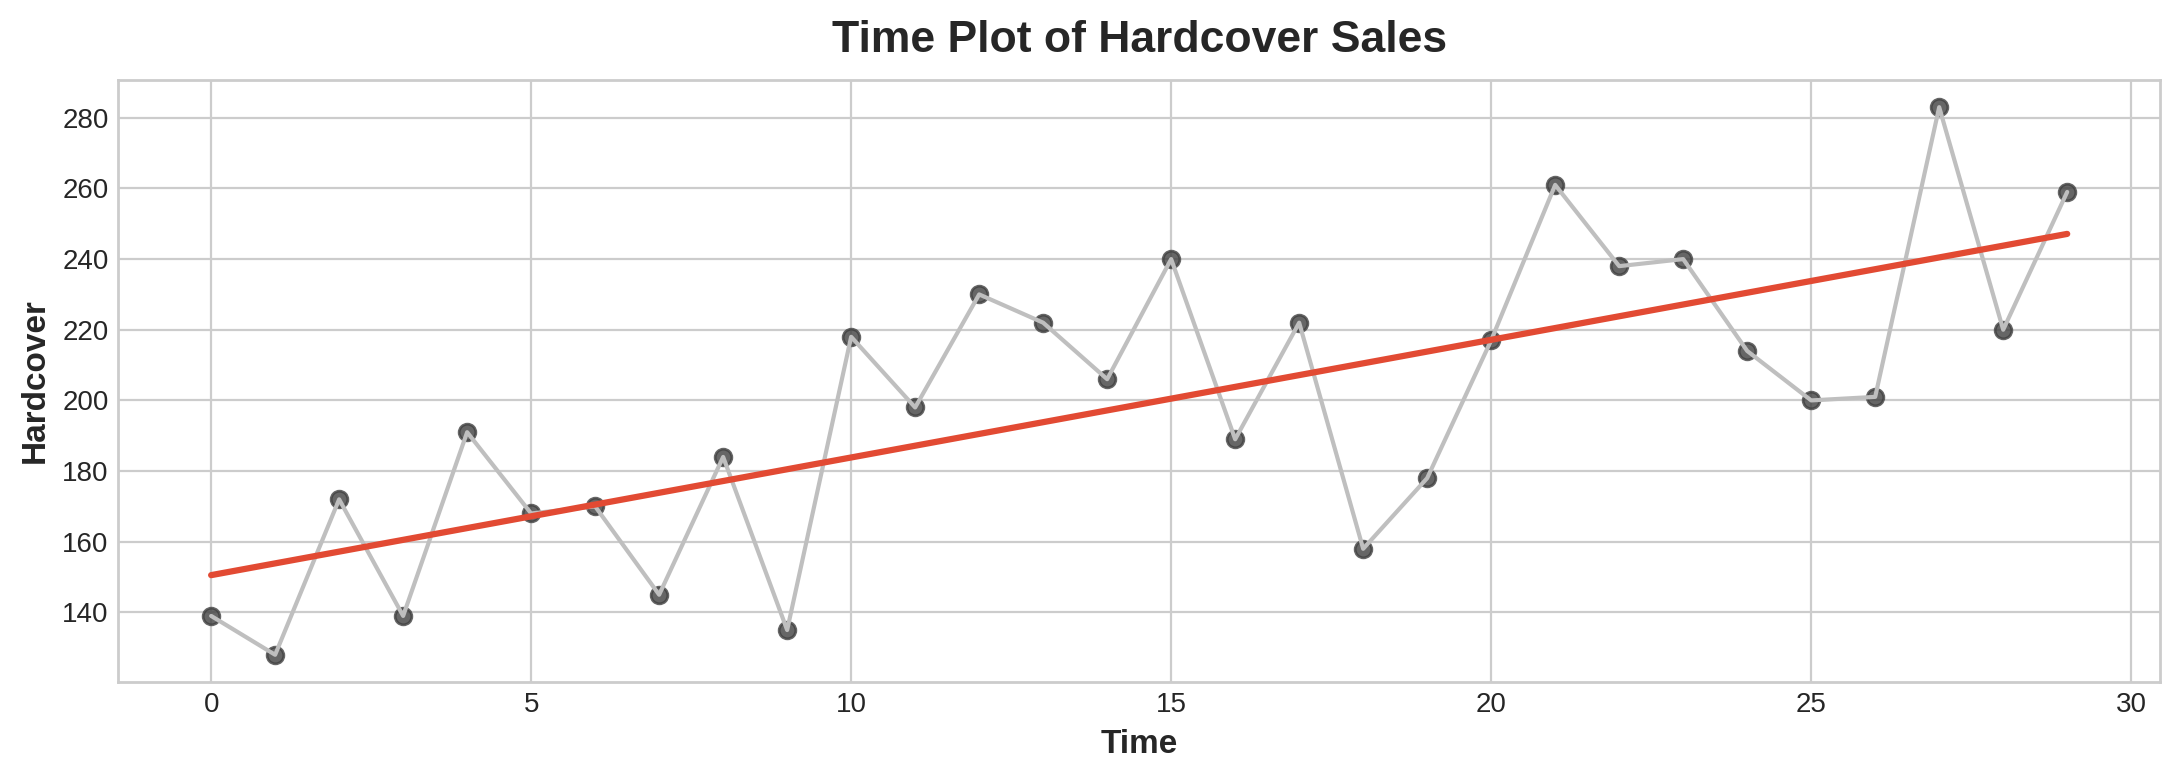

In [20]:
fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=book_sales, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=book_sales, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');

# 1) 타임 더미를 사용한 선형 회귀 해석하기

선형 회귀 직선은 대략 `Hardcover = 3.33 * Time + 150.5` 라는 방정식을 갖습니다. 6일 동안 양장본 판매량은 평균적으로 얼마나 변할 것으로 예상하나요? 생각해 본 뒤 다음 셀을 실행하세요.


In [21]:
# 해답을 보려면 이 줄을 실행하세요
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

A change of 6 steps in `Time` corresponds to an average change of 6 * 3.33 = 19.98 in `Hardcover` sales.


In [22]:
# 힌트가 필요하면 아래 줄의 주석을 해제하세요
# q_1.hint()

-------------------------------------------------------------------------------

회귀 계수를 해석하면 시계열 플롯에서 계열 의존성을 파악하는 데 도움이 됩니다. `error`는 무작위 잡음이고 `weight`는 -1과 1 사이의 값인 `target = weight * lag_1 + error` 모델을 생각해 보세요. 이 경우 `weight`는 다음 시점이 이전 시점과 같은 부호를 가질 가능성을 알려 줍니다. `weight`가 1에 가깝다면 `target`이 이전 단계와 같은 부호일 가능성이 높고, -1에 가깝다면 반대 부호일 가능성이 높습니다.

# 2) 래그 피처를 사용한 선형 회귀 해석하기

위에서 설명한 모델을 따르는 두 시계열을 보려면 다음 셀을 실행하세요.


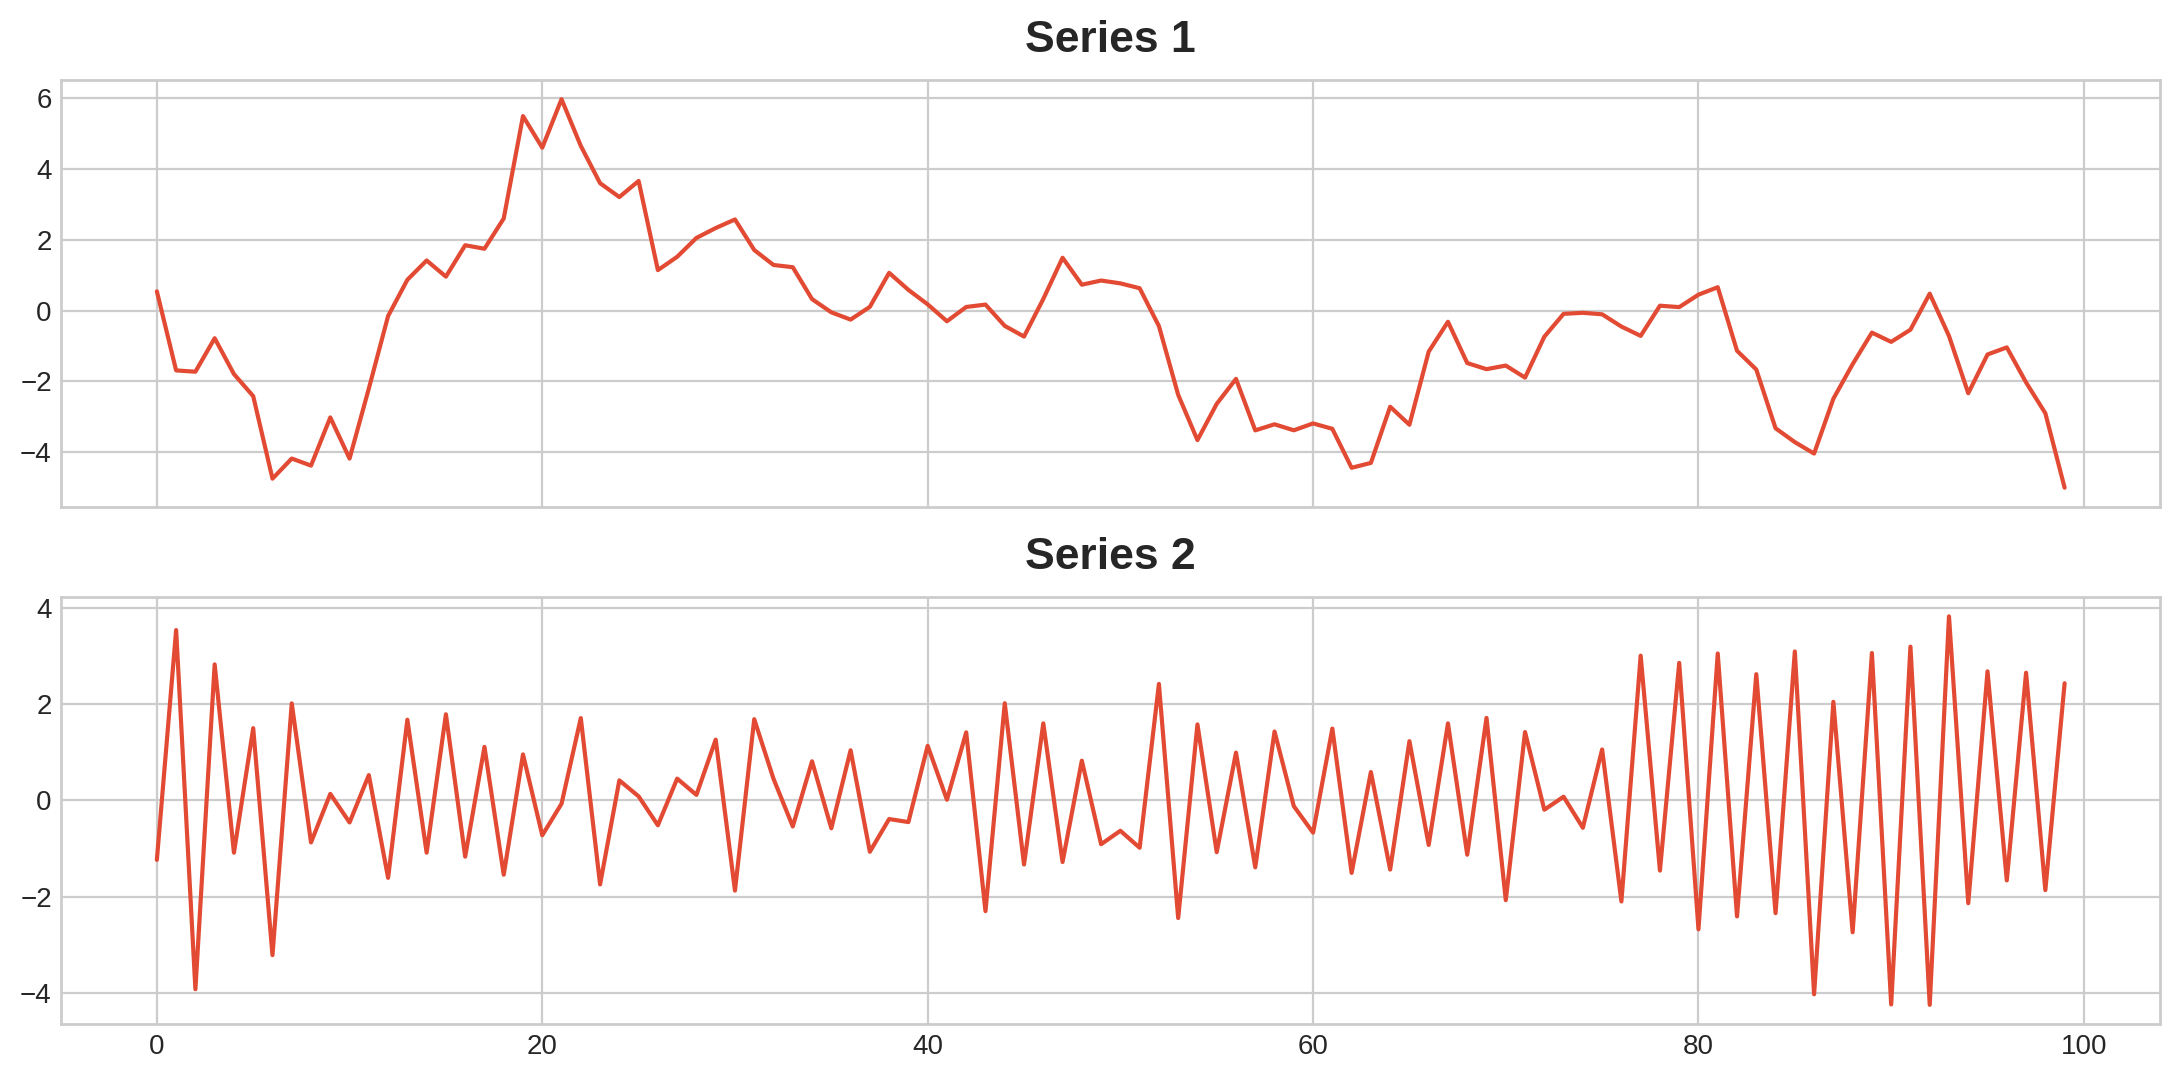

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 5.5), sharex=True)
ax1.plot(ar['ar1'])
ax1.set_title('Series 1')
ax2.plot(ar['ar2'])
ax2.set_title('Series 2');

이 중 하나의 시계열은 `target = 0.95 * lag_1 + error`, 다른 하나는 `target = -0.95 * lag_1 + error` 방정식을 갖고 있으며, 래그 피처의 부호만 다릅니다. 어떤 시계열이 어떤 방정식에 해당하는지 구분할 수 있나요?


In [24]:
# 해답을 보려면 이 줄을 실행하세요
# q_2.check()

In [25]:
# 힌트가 필요하면 아래 줄의 주석을 해제하세요
# q_2.hint()

-------------------------------------------------------------------------------

이제 *Store Sales - Time Series Forecasting* 대회 데이터를 살펴보겠습니다. 전체 데이터셋에는 2013년부터 2017년까지 다양한 제품군의 매출을 기록한 시계열이 거의 1800개나 있습니다. 이번 강의에서는 하루 평균 매출을 담은 단일 시계열(`average_sales`)만 사용합니다.

# 3) 시간 단계 피처 적합하기

아래 코드를 완성하여 평균 제품 매출 시계열에 시간 단계 피처를 사용한 선형 회귀 모델을 만드세요. 타깃은 `'sales'` 열에 있습니다.


In [36]:
from sklearn.linear_model import LinearRegression

df = average_sales.to_frame(name="sales")

# 여기에 코드를 작성하세요: 시간 더미(time dummy) 변수 만들기
time = range(len(df))

df['time'] = time

# 여기에 코드를 작성하세요: 훈련 데이터 만들기
X = df[['time']]  # features
y = df['sales']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# 훈련 데이터와 동일한 시간 인덱스를 가진
# 시계열 형태의 예측값 저장
y_pred = pd.Series(model.predict(X), index=X.index)




In [37]:
# 아래 줄들은 힌트 또는 정답 코드를 제공합니다.
# q_3.hint()
# q_3.solution()

결과를 그래프로 보고 싶다면 이 셀을 실행하세요.


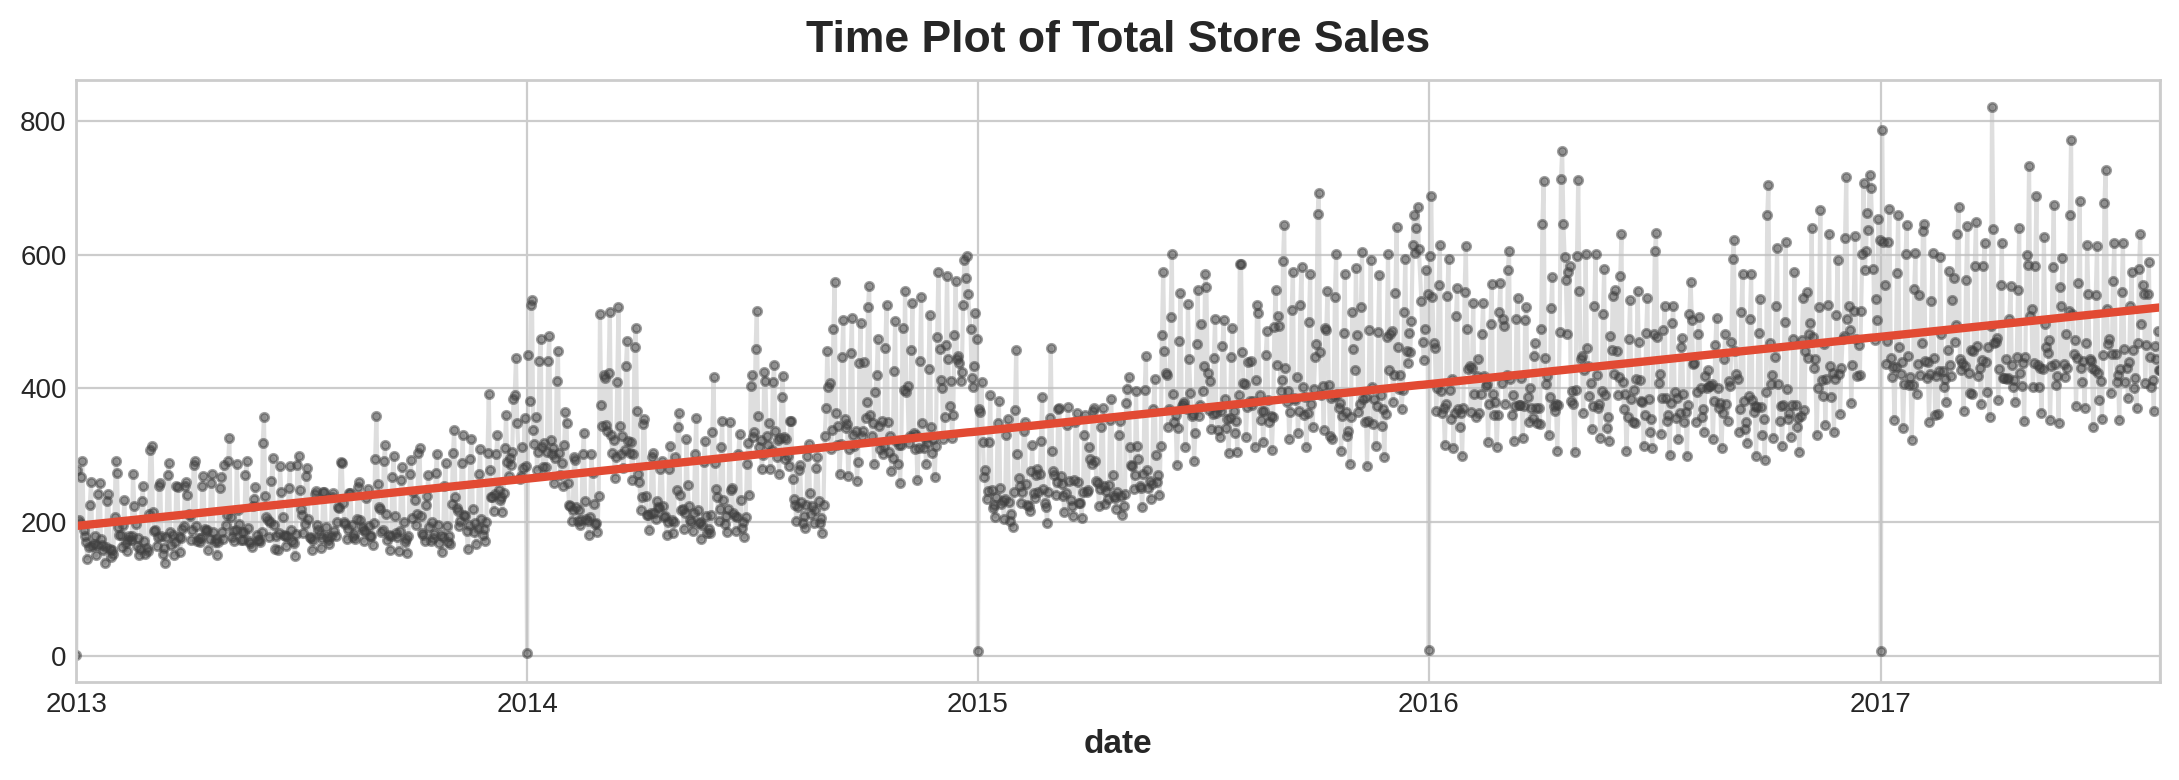

In [38]:
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

-------------------------------------------------------------------------------

# 4) Store Sales에 래그 피처 적용하기

아래 코드를 완성하여 평균 제품 매출 시계열에 래그 피처를 사용한 선형 회귀 모델을 만드세요. 타깃은 `df`의 `'sales'` 열에 있습니다.


In [39]:
df = average_sales.to_frame()

# 여기에 코드를 작성하세요: 타깃 변수 'sales'로부터 시차(lag) 특성을 만드세요.
lag_1 = df['sales'].shift(1)

df['lag_1'] = lag_1  # 데이터프레임에 lag_1 컬럼을 추가합니다.

X = df.loc[:, ['lag_1']].dropna()  # 피처(입력 변수)는 lag_1이며 결측치를 제거합니다.
y = df.loc[:, 'sales']  # 타깃 변수 y는 'sales' 컬럼입니다.
y, X = y.align(X, join='inner')  # 동일한 인덱스만 남기기 위해 y와 X의 행을 맞춥니다 (필요한 행만 남김).

#  여기에 코드를 작성하세요: LinearRegression 모델 객체를 만들고 X와 y에 학습시키세요.
model = LinearRegression()
model.fit(X, y)

# 여기에 코드를 작성하세요: 예측값을 훈련 데이터와
# 동일한 시간 인덱스를 가진 시계열로 저장하세요.
y_pred = pd.Series(model.predict(X), index=X.index)


In [40]:
# 아래 줄들은 힌트 또는 정답 코드를 제공합니다.
# q_4.hint()
# q_4.solution()

결과를 보고 싶다면 다음 셀을 실행하세요.


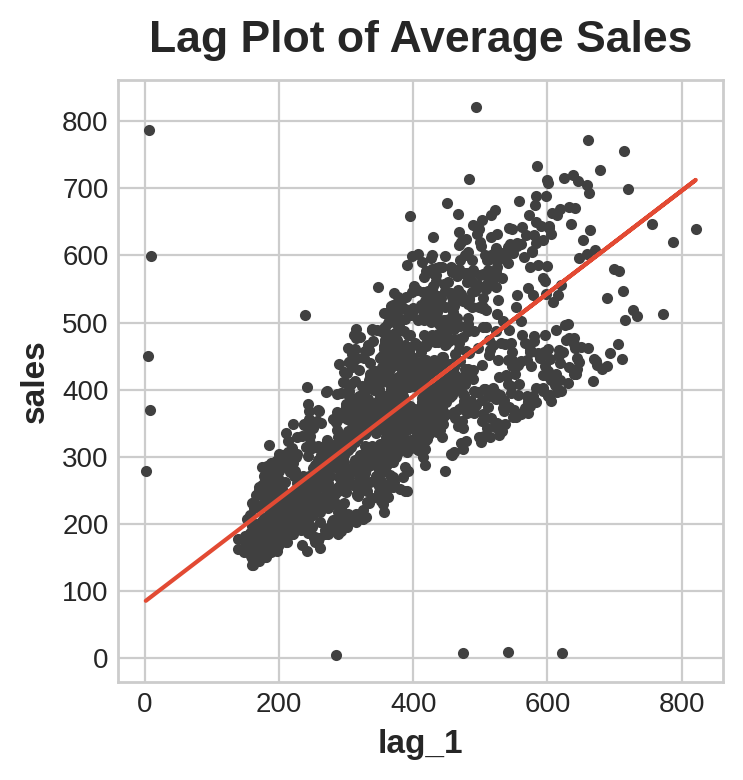

In [41]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');